In [1]:
# Only these three packages are allowed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class FLD:
    def __init__(self):
        """
            You can add/change any variables/methods to meet your need.
        """
        self.mean_vectors = None
        self.sw = None
        self.sb = None
        self.w = None
        self.slope = None
    
    def fit(self, X, y, wi = 1):
        class_num = np.max(y).astype(int)+1
        #Calculate self.mean_vectors
        self.mean_vectors = np.zeros((class_num,X.shape[1]))
        for i in range(class_num):
            self.mean_vectors[i] = np.mean(X[y == i],axis=0)
        #Calculate self.sw
        self.sw = np.zeros((X.shape[1],X.shape[1]))
        for i in range(class_num):
            X_wo_mean = X[y == i] - self.mean_vectors[i]
            self.sw += np.dot((X_wo_mean).T , X_wo_mean)
        
        #Calculate self.sb
        self.sb  = np.zeros((X.shape[1],X.shape[1]))
        all_mean = np.mean(X,axis = 0)
        for i in range(class_num):
            Ni = np.shape(X[y==i])[0]
            self.sb += Ni * np.dot((self.mean_vectors[i] - all_mean).T.reshape(-1,1) , (self.mean_vectors[i] - all_mean).reshape(1,-1))
        #Get the eigenvalue and eigenvector
        s = np.dot(np.linalg.inv(self.sw), self.sb)
        eigenvalue ,eigenvector = np.linalg.eig(s)
        eigenvector = eigenvector.T
        idxs = np.argsort(abs(eigenvalue))[::-1]
        eigenvalue = eigenvalue[idxs]
        eigenvector = eigenvector[idxs]        
        self.w = eigenvector[0:wi] 

    def predict_using_class_mean(self, X, y, X_test):
        class_num = np.max(y).astype(int)+1
        X_train_fld = np.dot(X, self.w.T)
        X_test_fld = np.dot(X_test, self.w.T)
        train_mean_fld = np.zeros([class_num,np.shape(X_train_fld)[1]])
        
        y_pred = np.zeros(np.shape(X_test)[0])
        for i in range(class_num):
            train_mean_fld[i] = np.mean(X_train_fld[y == i],axis=0)
        
        for i in range(np.shape(X_test_fld)[0]):
            distance = np.sqrt(np.sum(np.square(X_test_fld[i] - train_mean_fld),axis = 1))
            y_pred[i] = np.argmin(distance)
        return y_pred.astype(int)
        

    def predict_using_knn(self, X, y, X_test, k=1):
        X_train_fld = np.dot(X, self.w.T)
        X_test_fld = np.dot(X_test, self.w.T)
        y_pred = np.zeros(np.shape(X_test)[0])
        class_num = np.max(y).astype(int)+1
        
        distance = np.zeros(np.shape(X_train_fld)[0])
        for i in range(np.shape(X_test_fld)[0]):
            distance = np.sqrt(np.sum(np.square(X_test_fld[i] - X_train_fld),axis = 1))
            idxs = np.argsort(distance)
            y_idx = y[idxs].astype(int)
            y_pred[i] = np.argmax(np.bincount(y_idx[0:k]))
        return y_pred

    def show_confusion_matrix(self, y, y_pred):
        num_of_class = np.max(y).astype(int)+1
        npcm=np.zeros((num_of_class,num_of_class))
        for i in range(y.shape[0]):
          npcm[y[i],y_pred[i]] += 1
        threshold = np.max(npcm)/2
        plt.imshow(npcm,interpolation='nearest',cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.colorbar()

        class_name = []        
        for i in range(num_of_class):
            class_name.append(i)
        
        tick_index = np.arange(len(class_name))
        plt.xticks(tick_index,class_name, rotation=45)
        plt.yticks(tick_index,class_name)
        for i in range(npcm.shape[0]):
          for j in range(npcm.shape[1]):
            plt.text(j,i,format(npcm[i,j], '.2f'),horizontalalignment="center",color="white" if npcm[i,j] > threshold else "black")
        plt.tight_layout()
        plt.xlabel("Predicted label")
        plt.ylabel("True label")
        plt.show()

    def plot_projection(self, X, y):
        X_train_fld = np.dot(X, self.w.T).reshape(-1, 1) * self.w.reshape(2) / (np.dot(self.w.reshape(2), self.w.reshape(2)))
        print(np.shape(X_train_fld))
        X_0 = X[y == 0]
        X_1 = X[y == 1]
        X_2 = X[y == 2]
        X_train_fld_0 = X_train_fld[y == 0]
        X_train_fld_1 = X_train_fld[y == 1]        
        X_train_fld_2 = X_train_fld[y == 2]
        
        #projection line   
        intercept = 0
        self.slope = self.w[0][1]/self.w[0][0]
        print(self.slope)
        x = [np.min(X_train_fld), np.max(X_train_fld)]
        y = [self.slope*x[0]+intercept, self.slope*x[1]+intercept]
        plt.plot(x, y, c='k')

        # data to projection data   
        for i in range(np.shape(X)[0]):
            plt.plot(
                [X[i, 0], X_train_fld[i, 0]],
                [X[i, 1], X_train_fld[i, 1]], lw=0.4, alpha=0.1, c='b'
                )
    
        #data
        plt.scatter(X_0[:, 0], X_0[:, 1], s=5, c='r')
        plt.scatter(X_1[:, 0], X_1[:, 1], s=5, c='g')
        plt.scatter(X_2[:, 0], X_2[:, 1], s=5, c='y')
    
        # projected data point
        plt.scatter(X_train_fld_0[:, 0], X_train_fld_0[:, 1], s=5, c='r')
        plt.scatter(X_train_fld_1[:, 0], X_train_fld_1[:, 1], s=5, c='g')
        plt.scatter(X_train_fld_2[:, 0], X_train_fld_2[:, 1], s=5, c='y')
        
        title = "Projection line: w = " + \
        str(float(self.slope)) + ", b = " + str(intercept)
        plt.title(title)
        plt.show()
        
    def accuracy_score(self, y, y_pred):
        return (y_pred == y).sum()/np.shape(y)[0]

In [3]:
class MultiClassLogisticRegression:
    
    def __init__(self):
        """
            You can add/change any variables/methods to meet your need.
        """
        self.epoch = []
        self.train_loss = []
        self.weights = None

    def fit(self, X, y, batch_size=16, lr=0.001, epoch=100):
        num_of_class = np.max(y).astype(int)+1
        self.weights = np.ones((X.shape[1],num_of_class),dtype=float)
        for epoch_i in range(epoch):
            for batch in range(len(X)//batch_size):
                X_batch =  X[batch*batch_size : (batch+1)*batch_size]
                y_batch =  y[batch*batch_size : (batch+1)*batch_size]
                y_pred_batch = self.softmax(np.dot(X_batch , self.weights))
                y_one_hot_batch = np.eye(3)[y_batch.astype(int)].astype(float)      
                weights_gradient = np.dot(np.transpose(X_batch), y_pred_batch - y_one_hot_batch)/batch_size
                self.weights -= lr * weights_gradient
            self.epoch.append(epoch_i)
            #if ((epoch_i % 10) == 0):
            #    print("epoch ",epoch_i,": ",self.get_loss(X, y))
            self.train_loss.append(self.get_loss(X, y))

    def predict(self, X):
        return self.softmax(np.dot(X, self.weights)).argmax(axis=1)

    def get_loss(self, X, y):
        y_one_hot = np.eye(3)[y.astype(int)].astype(float)
        return self.cross_entropy(y_one_hot,self.softmax(np.dot(X, self.weights)))
    
    def evaluate(self, X, y):
        y_pred = self.predict(X)
        return self.accuracy_score(y, y_pred)

    def softmax(self, z):
        ex = np.exp(z)
        return ex / np.sum(ex, axis=1, keepdims=True)

    def cross_entropy(self, y, probs):
        return  np.average(- np.sum(np.log(probs) * y, axis=1))
    
    def accuracy_score(self, y, y_pred):
        return (y_pred == y).sum()/np.shape(y)[0]

    def show_confusion_matrix(self, X, y):
        num_of_class = np.max(y).astype(int)+1
        y_pred = self.predict(X)
        npcm=np.zeros((num_of_class,num_of_class))
        for i in range(y.shape[0]):
          npcm[y[i],y_pred[i]] += 1
        threshold = np.max(npcm)/2
        plt.imshow(npcm,interpolation='nearest',cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.colorbar()

        class_name = []        
        for i in range(num_of_class):
            class_name.append(i)
        
        tick_index = np.arange(len(class_name))
        plt.xticks(tick_index,class_name, rotation=45)
        plt.yticks(tick_index,class_name)
        for i in range(npcm.shape[0]):
          for j in range(npcm.shape[1]):
            plt.text(j,i,format(npcm[i,j], '.2f'),horizontalalignment="center",color="white" if npcm[i,j] > threshold else "black")
        plt.tight_layout()
        plt.xlabel("Predicted label")
        plt.ylabel("True label")
        plt.show()
    
    def plot_curve(self):
        # self.epoch and self.train_loss may be helpful here. 
        plt.plot(self.epoch, self.train_loss,'b' ,label = "Training loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

# Prepare data for Q1 ~ Q12

In [4]:
df_train = pd.DataFrame(pd.read_csv("./PR_HW2_blob_train.csv"))
df_test  = pd.DataFrame(pd.read_csv("./PR_HW2_blob_test.csv"))

In [5]:
X_train = df_train[['Feature1', 'Feature2']].to_numpy()
y_train = df_train[['Target']].to_numpy().ravel()

X_test = df_test[['Feature1', 'Feature2']].to_numpy()
y_test = df_test[['Target']].to_numpy().ravel()



print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test",  X_test.shape)
print("y_test",  y_test.shape)

X_train (1000, 2)
y_train (1000,)
X_test (1000, 2)
y_test (1000,)


# MultiClass Logistic Regression

In [6]:
# For Q1
lr = 1e-5
batch_size = 1
epoch = 20000

X_train = np.concatenate((X_train, np.ones([X_train.shape[0], 1])), axis = 1).astype(float)
X_test = np.concatenate((X_test, np.ones([X_test.shape[0], 1])), axis = 1).astype(float)

logistic_reg = MultiClassLogisticRegression()
logistic_reg.fit(X_train, y_train, lr=lr, batch_size=batch_size, epoch=epoch)

In [7]:
# For Q2
print('Training acc: ', logistic_reg.evaluate(X_train, y_train))

Training acc:  0.893


In [8]:
# For Q3
print('Testing acc: ', logistic_reg.evaluate(X_test, y_test))

Testing acc:  0.881


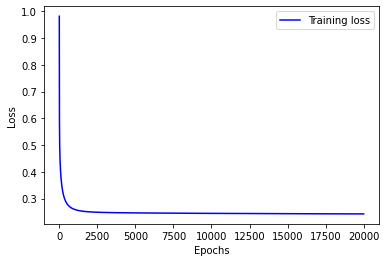

In [9]:
# For Q4
logistic_reg.plot_curve()

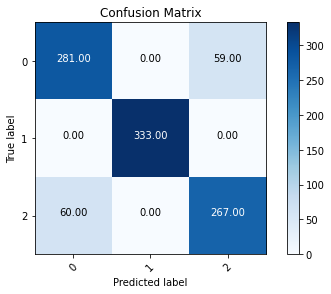

In [10]:
# For Q5
logistic_reg.show_confusion_matrix(X_test, y_test)

# Fisher's Linear Discriminant Analysis

In [11]:
X_train = np.delete(X_train, -1,axis = 1)
X_test = np.delete(X_test, -1,axis = 1)

fld = FLD()

fld.fit(X_train, y_train)

In [12]:
# For Q6
print("Class mean vector: ", fld.mean_vectors)

Class mean vector:  [[-4.17505764  6.35526804]
 [-9.43385176 -4.87830741]
 [-2.54454008  7.53144179]]


In [13]:
# For Q7
print("Within-class scatter matrix SW: ", fld.sw)

Within-class scatter matrix SW:  [[1052.70745046  -12.5828441 ]
 [ -12.5828441   971.29686189]]


In [14]:
# For Q8
print("Between-class scatter matrix SB: ", fld.sb)

Between-class scatter matrix SB:  [[ 8689.12907035 16344.86572983]
 [16344.86572983 31372.93949414]]


In [15]:
# For Q9
print("W: ", fld.w)

W:  [[-0.44115384 -0.8974315 ]]


FLD using class mean, accuracy:  0.861


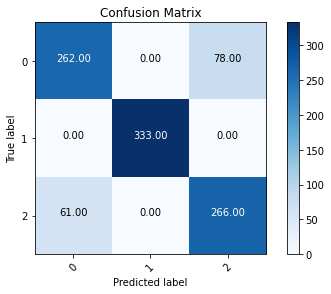

In [16]:
# For Q10
y_pred = fld.predict_using_class_mean(X_train, y_train, X_test)
print("FLD using class mean, accuracy: ", fld.accuracy_score(y_test, y_pred))
fld.show_confusion_matrix(y_test, y_pred)

In [17]:
# For Q11
y_pred_k1 = fld.predict_using_knn(X_train, y_train, X_test, k=1)
print("FLD using knn (k=1), accuracy: ", fld.accuracy_score(y_test, y_pred_k1))

y_pred_k2 = fld.predict_using_knn(X_train, y_train, X_test, k=2)
print("FLD using knn (k=2), accuracy: ", fld.accuracy_score(y_test, y_pred_k2))

y_pred_k3 = fld.predict_using_knn(X_train, y_train, X_test, k=3)
print("FLD using knn (k=3), accuracy: ", fld.accuracy_score(y_test, y_pred_k3))

y_pred_k4 = fld.predict_using_knn(X_train, y_train, X_test, k=4)
print("FLD using knn (k=4), accuracy: ", fld.accuracy_score(y_test, y_pred_k4))

y_pred_k5 = fld.predict_using_knn(X_train, y_train, X_test, k=5)
print("FLD using knn (k=5), accuracy: ", fld.accuracy_score(y_test, y_pred_k5))

FLD using knn (k=1), accuracy:  0.822
FLD using knn (k=2), accuracy:  0.819
FLD using knn (k=3), accuracy:  0.843
FLD using knn (k=4), accuracy:  0.84
FLD using knn (k=5), accuracy:  0.862


(1000, 2)
2.0342824077373742


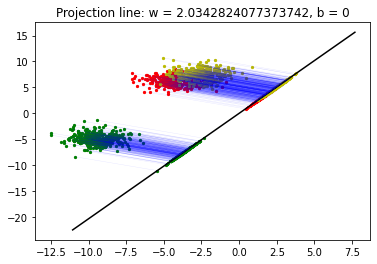

In [18]:
# For Q12, using only training data
fld.plot_projection(X_train, y_train)

# Train your own model on provided dataset.
You can only using 1) **Fisher's Linear Discriminant** or 2) **Logistic Regression** that you have implemented above.

In [19]:
df_train = pd.DataFrame(pd.read_csv("./PR_HW2_train.csv"))
df_val   = pd.DataFrame(pd.read_csv("./PR_HW2_val.csv"))
df_test  = pd.DataFrame(pd.read_csv("./PR_HW2_test.csv"))

In [20]:
df_train.head()

,Feature1,Feature2,Feature3,Feature4,Target
0,0.00668,0.00192,0.682,0.996,2.0
1,0.00680,0.00106,0.503,0.996,1.0
2,0.00742,0.00106,0.482,0.991,1.0
3,0.00685,0.00178,0.650,0.998,2.0
4,0.00680,0.00163,0.623,0.996,2.0


In [21]:
df_test.head()

,Feature1,Feature2,Feature3,Feature4,Target
0,0.00699,0.000877,0.451,0.994,NaN
1,0.00736,0.001370,0.549,0.998,NaN
2,0.00687,0.001420,0.580,0.992,NaN
3,0.00752,0.002520,0.737,0.996,NaN
4,0.00685,0.000910,0.464,0.992,NaN


In [22]:
# Data processing

# Refer to section "Prepare data for Q1 ~ Q12"
x_train_df = df_train.drop(['Target'], axis=1)
y_train_df = df_train['Target']

x_val_df = df_val.drop(['Target'], axis=1)
y_val_df = df_val['Target']

x_test_df = df_test.drop(['Target'], axis=1)

x_train = x_train_df.to_numpy()
y_train = y_train_df.to_numpy()

x_val = x_val_df.to_numpy()
y_val = y_val_df.to_numpy()

x_test = x_test_df.to_numpy()


In [23]:
# Train your model here
'''
max_wi = 0
max_ki = 0
best_acc =0

max_wi_avg = 0
best_acc_avg = 0
for w_i in range(1,5):
    your_model = FLD()
    your_model.fit(x_train, y_train, wi = w_i)
    for k_i in range(1,200):
        y_pred_k = your_model.predict_using_knn(x_train, y_train, x_val, k=k_i)
        print("FLD using knn (k=",k_i,"), accuracy: ", your_model.accuracy_score(y_val, y_pred_k))
        if best_acc < your_model.accuracy_score(y_val, y_pred_k):
            max_wi = w_i
            max_ki = k_i
            best_acc = your_model.accuracy_score(y_val, y_pred_k)
            
print("max wi: ", max_wi)
print("max ki: ", max_ki)
print("max best_acc:", best_acc)
'''
your_model = FLD()
your_model.fit(x_train, y_train, wi = 2)

In [24]:
#Evaluating
y_pred_val = your_model.predict_using_knn(x_train, y_train, x_val, k=34)
print("Evaluating accuracy: ", your_model.accuracy_score(y_val, y_pred_val))

Evaluating accuracy:  0.9246575342465754


In [25]:
test_pred = your_model.predict_using_knn(x_train, y_train, x_test, k=34)
print("test_pred shape: ", test_pred.shape)

test_pred shape:  (5677,)


# Output the csv file

In [26]:
# For Q13
df_test = pd.DataFrame(pd.read_csv("./PR_HW2_test.csv"))
df_test["Target"] = test_pred
df_test.to_csv("0810749_prediction.csv")